In [1]:
%load_ext autoreload
%autoreload 2

# Helmholtz problem

This example notebook shows how to setup and solve the time-harmonic acoustic propagation problem, which is governed by the Helmholtz equation.

The Helmholtz equation is given by Fourier transforming the wave equation in the temporal domain, which gives

$$
    \left(\nabla +\frac{\omega^2}{c^2}\right)\phi = i \omega S_M,
$$

with $P, S_M \in C^{2}(\mathbb{C})$. 

In `jwave`, the Helmholtz equation solved also takes into account heterogeneous absorption and density, and it is given as
$$
\left(\frac{\omega^2}{c_0^2} + \nabla^2  - \frac{1}{\rho_0} \nabla \rho_0 \cdot \nabla  + \frac{2i\omega^3\alpha_0}{c_0} \right)P = i \omega S_M
$$
where:
- $\omega =2\pi f_0$ is the angular frequency, and $f_0$ is the frequency of the wave
- $\rho_0$ is the material density
- $\alpha_0$ is the attenuation coefficient
- $S_M$ is the mass source term

Before running the simulation, we'll import the necessary modules and utility functions

In [2]:
from jwave.geometry import Domain, Medium, _circ_mask
from jwave.acoustics import ongrid_helmholtz_solver
from jwave.utils import plot_complex_field

import numpy as np
from jax import numpy as jnp
from jax import random, jit
from functools import partial
from matplotlib import pyplot as plt

key = random.PRNGKey(42)

Performing time-harmonic simulations is very similar to standard wave propagation, with the difference that the source field is a static complex field.

In [3]:
# Defining geometry
N = (128, 256)         # Grid size
dx = (1., 1.)          # Spatial resolution
omega = 1.              # Wavefield omega = 2*pi*f
target = [160,360]     # Target location

# Making geometry
domain = Domain(N, dx)

# Build the vector that holds the parameters of the apodization an the
# functions required to transform it into a source wavefield
transmit_phase = jnp.concatenate([jnp.ones((2,)), jnp.ones((2,))])
position = list(range(32, 32+4, 2))

src_field = jnp.zeros(N).astype(jnp.complex64)
src_field = src_field.at[64, 22].set(1.0)

In [22]:
def setup_simulation(medium, solver="gmres"):
    params, solver = ongrid_helmholtz_solver(
        medium, 
        omega=omega,
        tol=1e-5, 
        restart=5,
        method=solver,
        maxiter=1000,
        source = src_field,
        checkpoint=True
    )
    return params, jit(solver)

In [23]:
# Constructing medium physical properties
sound_speed = jnp.zeros(N)
sound_speed = sound_speed.at[20:105,20:200].set(1.)
sound_speed = sound_speed*(1-_circ_mask(N, 90,[64,180]))*(1-_circ_mask(N,50,[64,22])) +1
medium = Medium(
    domain=domain,
    sound_speed=sound_speed,
    density=1.,
    attenuation=None,
    pml_size=15
)

(<Figure size 1080x576 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Real wavefield'}>,
        <AxesSubplot:title={'center':'Wavefield magnitude'}>], dtype=object))

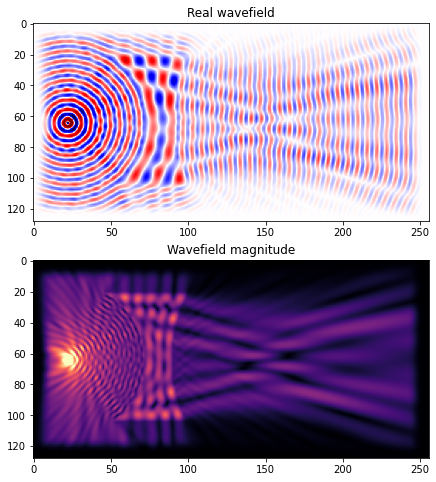

In [24]:
params, solver = setup_simulation(medium, "gmres")
field = solver(params)
plot_complex_field(field, max_intensity=0.1)

In [25]:
print("Runtime with GMRES")
%timeit solver(params).block_until_ready()

Runtime with GMRES
1.15 s ± 128 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
params, solver = setup_simulation(medium, "bicgstab")
field = solver(params)

print("Runtime with BiCGSTAB")
%timeit solver(params).block_until_ready()

Runtime with BiCGSTAB
179 ms ± 1.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
density = jnp.ones(N)
density = density.at[:64, 170:].set(1.5)

medium = Medium(
    domain=domain,
    sound_speed=sound_speed,
    density=density,
    attenuation=None,
    pml_size=15
)

(<Figure size 1080x576 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Real wavefield'}>,
        <AxesSubplot:title={'center':'Wavefield magnitude'}>], dtype=object))

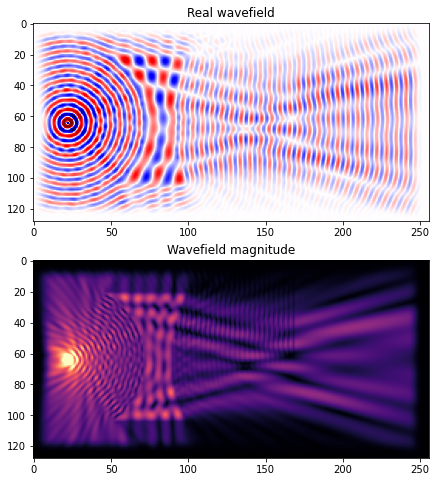

In [28]:
params, solver = setup_simulation(medium, "gmres")
field = solver(params)
plot_complex_field(field, max_intensity=0.1)

In [13]:
attenuation = jnp.zeros(N)
attenuation = attenuation.at[64:110,125:220].set(0.1)

medium = Medium(
    domain=domain,
    sound_speed=sound_speed,
    density=1.,
    attenuation=attenuation,
    pml_size=15
)

(<Figure size 1080x576 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Real wavefield'}>,
        <AxesSubplot:title={'center':'Wavefield magnitude'}>], dtype=object))

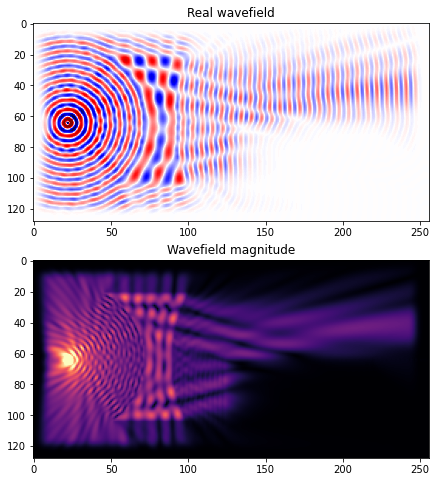

In [14]:
params, solver = setup_simulation(medium, "gmres")
field = solver(params)
plot_complex_field(field, max_intensity=0.1)

(<Figure size 1080x576 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Real wavefield'}>,
        <AxesSubplot:title={'center':'Wavefield magnitude'}>], dtype=object))

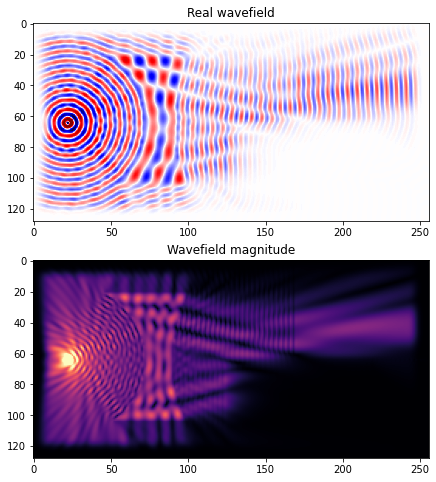

In [15]:
medium = Medium(
    domain=domain,
    sound_speed=sound_speed,
    density=density,
    attenuation=attenuation,
    pml_size=15
)
params, solver = setup_simulation(medium, "gmres")
field = solver(params)
plot_complex_field(field, max_intensity=0.1)